In [1]:
%load_ext autoreload
%load_ext autotime
%autoreload 2

## Imports & Settings

In [2]:
import os, sys
import warnings

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

# disabling log messages from TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# creating an end of run alarm
from IPython.display import Audio
sound_file = '/Users/dsbox/Documents/Flatiron/phase_5/WAILERLP.wav'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
%matplotlib inline

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette('GnBu_r')
pd.options.display.max_rows = 300

from src import helper_functions as f
from src import visualizations as v
from src import class_Database as d
from src import class_Harness as h

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, make_scorer, confusion_matrix)
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import (BaggingClassifier, AdaBoostClassifier,
                              RandomForestClassifier, VotingClassifier)

# import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

from keras import layers, models, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

time: 6.02 s


## Creating The Database

In [3]:
# creating database & database class instance
database_name = 'outcomes.db'
db = d.Database(database_name)

time: 1.79 ms


**Run The Cell Below Once And Then Comment Out**

In [4]:
# file_name = 'anonymisedData.zip'
# db.populate(file_name, database_name)

time: 527 µs


### Database ERD

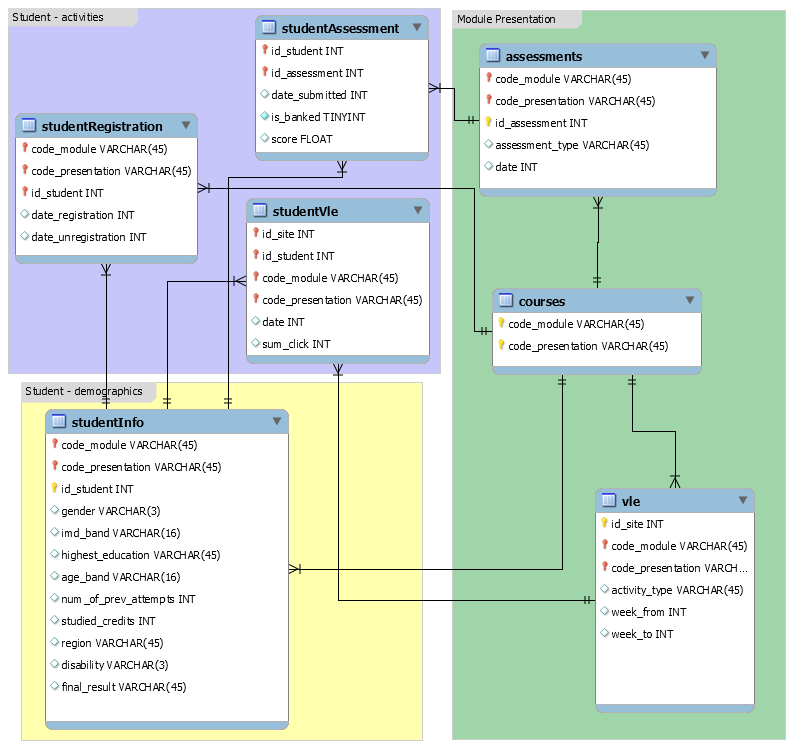

time: 4.33 ms


In [5]:
db.erd

## Preprocessing and Harness Objects

In [6]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

preprocessing_ohe = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector))
preprocessing_ss = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))
preprocessing_mm = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (MinMaxScaler(), number_selector))

time: 1.59 ms


In [7]:
# creating accuracy scorer
accuracy = f.acc_score

# creating f1 scorer
f1 = f.f1

# creating recall scorer 
recall = f.recall

# creating precision scorer
precision = f.precision

# creating Harness
modeling = h.Harness(('accuracy', 'f1', 'recall', 'precision'))

time: 3.28 ms


# STUDENTINFO Data

In [8]:
db.table_info('STUDENTINFO')

[(0, 'code_module', 'TEXT', 0, None, 0),
 (1, 'code_presentation', 'TEXT', 0, None, 0),
 (2, 'id_student', 'TEXT', 0, None, 0),
 (3, 'gender', 'TEXT', 0, None, 0),
 (4, 'region', 'TEXT', 0, None, 0),
 (5, 'highest_education', 'TEXT', 0, None, 0),
 (6, 'imd_band', 'TEXT', 0, None, 0),
 (7, 'age_band', 'TEXT', 0, None, 0),
 (8, 'num_of_prev_attempts', 'TEXT', 0, None, 0),
 (9, 'studied_credits', 'TEXT', 0, None, 0),
 (10, 'disability', 'TEXT', 0, None, 0),
 (11, 'final_result', 'TEXT', 0, None, 0)]

time: 3.7 ms


## Creating STUDENTINFO Data Frame

In [9]:
df = db.student_info()

time: 168 ms


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  object
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  object
 9   studied_credits       32593 non-null  object
 10  disability            32593 non-null  object
 11  final_result          32593 non-null  object
 12  row_id                32593 non-null  object
 13  target                32593 non-null  int64 
dtypes: int64(1), object(13)
memory usage: 3.5+ MB
time: 27.4 ms


In [11]:
df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,row_id,target
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,AAA2013J11391,1
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,AAA2013J28400,1
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,AAA2013J30268,0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,AAA2013J31604,1
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,AAA2013J32885,1


time: 16 ms


In [12]:
df = db.sql_fixes(df)

time: 54.7 ms


In [13]:
drops = ['row_id', 'code_module', 'code_presentation',
         'id_student', 'final_result', 'studied_credits']

time: 738 µs


In [14]:
df = db.pipe_cleaner(df, drops)

time: 68.5 ms


In [15]:
df.target.value_counts(normalize=True)

0    0.531724
1    0.468276
Name: target, dtype: float64

time: 4.03 ms


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31144 entries, 1 to 32592
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                31144 non-null  int64   
 1   gender                31144 non-null  object  
 2   region                31144 non-null  object  
 3   highest_education     31144 non-null  object  
 4   imd_band              31144 non-null  object  
 5   age_band              31144 non-null  object  
 6   num_of_prev_attempts  31144 non-null  object  
 7   disability            31144 non-null  object  
 8   course_load           31144 non-null  category
dtypes: category(1), int64(1), object(7)
memory usage: 2.2+ MB
time: 18.5 ms


## Creating Holdout Data

In [17]:
# splitting data & target
X, y = f.X_y(df)

time: 3.94 ms


In [18]:
# splitting training and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 13 ms


## Creating Training Data

In [19]:
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 12.3 ms


## Baseline Model: Dummy Classifier

In [20]:
dummy = DummyClassifier(strategy='most_frequent')

time: 678 µs


In [21]:
baseline = make_pipeline(preprocessing_ohe, dummy)

time: 778 µs


### Fitting Model

In [22]:
baseline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>)])),
                ('dummyclassifier', DummyClassifier(strategy='most_frequent'))])

time: 62.6 ms


### Saving Model

In [23]:
# f.pickle_model(baseline, 'baseline')

time: 576 µs


### Cross Val Scores

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    modeling.report(baseline, X_train, y_train, ' Baseline', 'Baseline DummyCFL')

 Baseline has an average Accuracy of 0.5317387933630273
 Baseline has an average F1 of 0.0
 Baseline has an average Recall of 0.0
 Baseline has an average Precision of 0.0
time: 273 ms


### Test Data Confusion Matrix

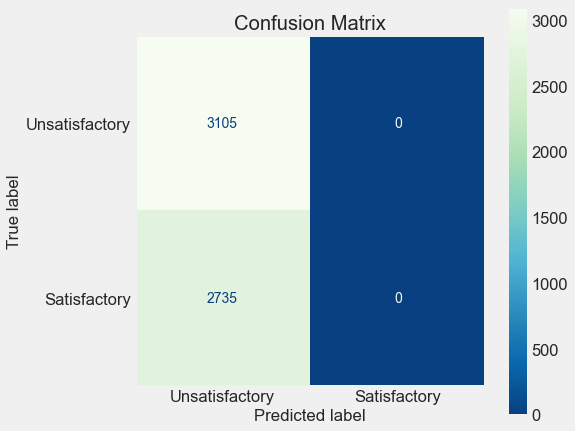

,Accuracy,F1,Recall,Precision
0,0.531678,0.0,0.0,0.0


time: 345 ms


In [25]:
%%capture --no-display
f.confusion_report(baseline, X_test, y_test, 'baseline')

## First Simple Model: Naive Bayes Classifier

In [26]:
mnb = MultinomialNB()

time: 707 µs


In [27]:
fsm = make_pipeline(preprocessing_ohe, mnb)

time: 832 µs


### Fitting Model

In [28]:
fsm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>)])),
                ('multinomialnb', MultinomialNB())])

time: 57.6 ms


### Saving Model

In [29]:
# f.pickle_model(fsm, 'fsm')

time: 611 µs


### Cross Val Scores

In [30]:
# checking cross val scores
modeling.report(fsm, X_train, y_train, ' fsm', 'FSM Naive Bayes')

 fsm has an average Accuracy of 0.5977842703644757
 fsm has an average F1 of 0.5501464797462071
 fsm has an average Recall of 0.525293693613353
 fsm has an average Precision of 0.5775534699218401
time: 310 ms


### Test Data Confusion Matrix

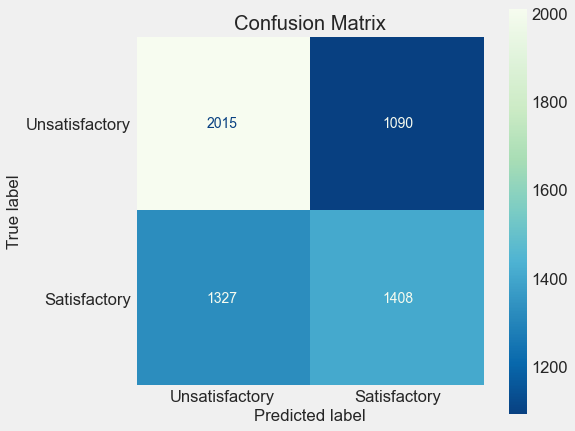

,Accuracy,F1,Recall,Precision
0,0.58613,0.538123,0.514808,0.563651


time: 353 ms


In [31]:
f.confusion_report(fsm, X_test, y_test, 'fsm')

## KNeighborsClassifier

In [32]:
KNN = KNeighborsClassifier(n_jobs=-1)

time: 764 µs


In [33]:
knn = make_pipeline(preprocessing_ohe, KNN)

time: 770 µs


### Fitting Model

In [34]:
knn.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 58.9 ms


In [35]:
# f.pickle_model(knn, 'knn')

time: 615 µs


### Cross Val Scores

In [36]:
# checking cross val scores
modeling.report(knn, X_train, y_train, 'knn', 'KNN')

knn has an average Accuracy of 0.5416712126722432
knn has an average F1 of 0.4992496956309013
knn has an average Recall of 0.4881125429170196
knn has an average Precision of 0.5110050074098231
time: 8.37 s


### Test Data Confusion Matrix

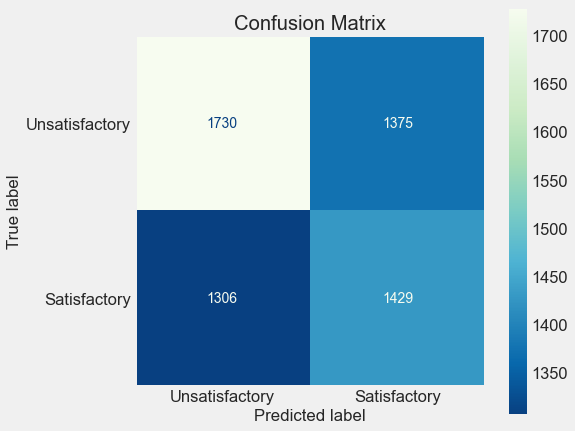

,Accuracy,F1,Recall,Precision
0,0.540925,0.515978,0.522486,0.509629


time: 17.8 s


In [37]:
f.confusion_report(knn, X_test, y_test)

## Logistic Regression Classifier

In [38]:
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021, verbose=0)

time: 995 µs


In [39]:
logreg = make_pipeline(preprocessing_ohe, LR)

time: 931 µs


### Fitting Model

In [40]:
logreg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 4.76 s


In [41]:
# f.pickle_model(logreg, 'logreg')

time: 731 µs


### Cross Val Scores

In [42]:
# checking cross val scores
modeling.report(logreg, X_train, y_train, 'logreg', 'Logistic Regression')

logreg has an average Accuracy of 0.6001819868683985
logreg has an average F1 of 0.5475366605497606
logreg has an average Recall of 0.5167591890726951
logreg has an average Precision of 0.5823352402757835
time: 6.33 s


### Test Data Confusion Matrix

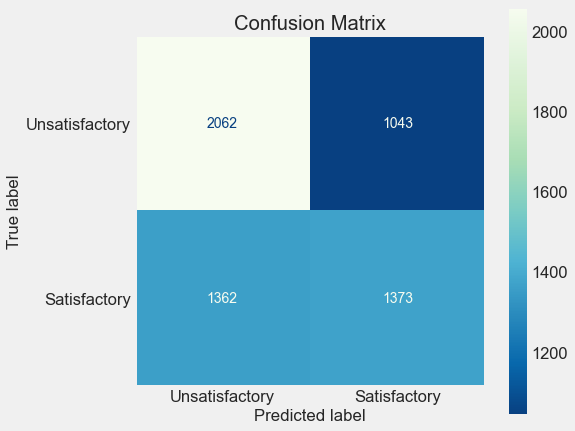

,Accuracy,F1,Recall,Precision
0,0.588185,0.5331,0.502011,0.568295


time: 238 ms


In [43]:
f.confusion_report(logreg, X_test, y_test)

## Support Vector Machine

In [44]:
SVC = SVC()

time: 780 µs


In [45]:
svc = make_pipeline(preprocessing_ohe, SVC)

time: 825 µs


### Fitting Model

In [46]:
svc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>)])),
                ('svc', SVC())])

time: 15.8 s


In [47]:
# f.pickle_model(svc, 'svc')

time: 648 µs


### Cross Val Scores

In [48]:
# checking cross val scores
modeling.report(svc, X_train, y_train, 'svc', 'Support Vector Classifier')

svc has an average Accuracy of 0.5958439406796784
svc has an average F1 of 0.5358496599574315
svc has an average Recall of 0.4982321160505938
svc has an average Precision of 0.5796742944310178
time: 1min


### Test Data Confusion Matrix

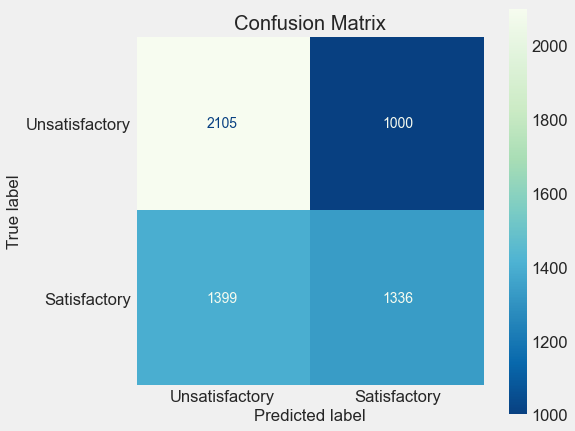

,Accuracy,F1,Recall,Precision
0,0.589212,0.526918,0.488483,0.571918


time: 19.4 s


In [49]:
f.confusion_report(svc, X_test, y_test)

## Linear Support Vector Machine

In [50]:
LSVC = LinearSVC()

time: 771 µs


In [51]:
lsvc = make_pipeline(preprocessing_ohe, LSVC)

time: 836 µs


### Fitting Model

In [52]:
lsvc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>)])),
                ('linearsvc', LinearSVC())])

time: 260 ms


In [53]:
# f.pickle_model(lsvc, 'lsvc')

time: 636 µs


### Cross Val Scores

In [54]:
# checking cross val scores
modeling.report(lsvc, X_train, y_train, 'lsvc', 'Linear SVC')

lsvc has an average Accuracy of 0.5993828023468468
lsvc has an average F1 of 0.5469839028613485
lsvc has an average Recall of 0.5166371635379974
lsvc has an average Precision of 0.5812500232465289
time: 931 ms


### Test Data Confusion Matrix

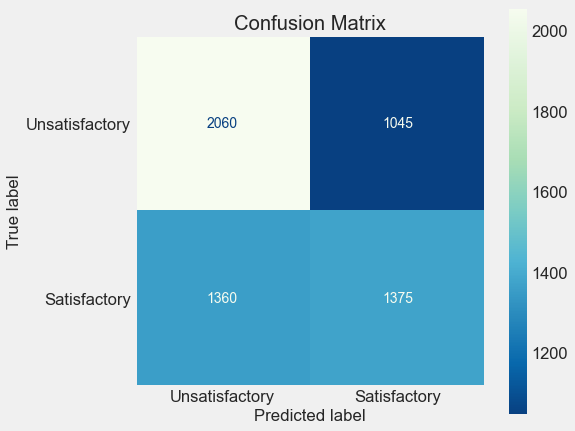

,Accuracy,F1,Recall,Precision
0,0.588185,0.533463,0.502742,0.568182


time: 236 ms


In [55]:
f.confusion_report(lsvc, X_test, y_test)

## Decision Tree

In [56]:
DT = DecisionTreeClassifier(random_state=2021)

time: 819 µs


In [57]:
dt = make_pipeline(preprocessing_ohe, DT)

time: 871 µs


### Fitting Model

In [58]:
dt.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 292 ms


In [59]:
# f.pickle_model(dt, 'dt')

time: 634 µs


### Cross Val Scores

In [60]:
# checking cross val scores
modeling.report(dt, X_train, y_train, 'dt', 'Decision Tree')

dt has an average Accuracy of 0.5521748970549705
dt has an average F1 of 0.47941947817829184
dt has an average Recall of 0.4404471544715447
dt has an average Precision of 0.5260781789611958
time: 1.02 s


### Test Data Confusion Matrix

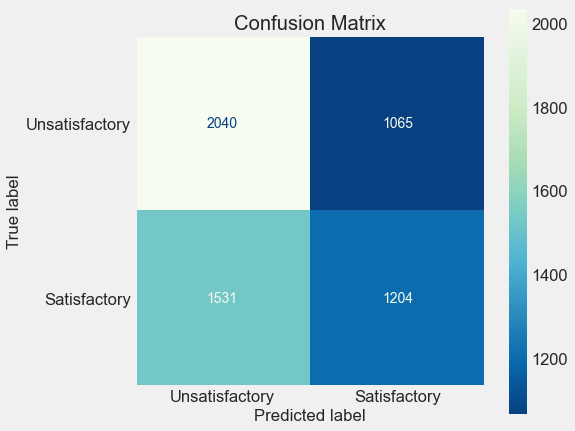

,Accuracy,F1,Recall,Precision
0,0.555479,0.481215,0.440219,0.53063


time: 238 ms


In [61]:
f.confusion_report(dt, X_test, y_test)

## Bagging Classifier

In [62]:
BCLF = BaggingClassifier(base_estimator=DT, random_state=2021)

time: 757 µs


In [63]:
bclf = make_pipeline(preprocessing_ohe, BCLF)

time: 962 µs


### Fitting Model

In [64]:
bclf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 1.92 s


In [65]:
# f.pickle_model(bclf, 'bclf')

time: 591 µs


### Cross Val Scores

In [66]:
# checking cross val scores
modeling.report(bclf, X_train, y_train, 'bclf', 'Bagging CLF')

bclf has an average Accuracy of 0.5560561755937832
bclf has an average F1 of 0.5115555495803096
bclf has an average Recall of 0.4966454125235951
bclf has an average Precision of 0.5275220302594841
time: 6.68 s


### Test Data Confusion Matrix

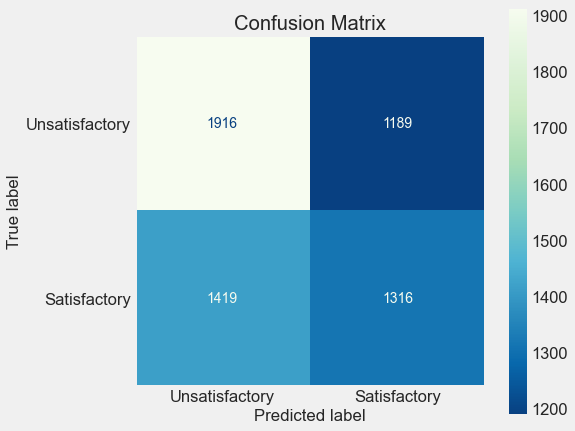

,Accuracy,F1,Recall,Precision
0,0.553425,0.50229,0.48117,0.525349


time: 306 ms


In [67]:
f.confusion_report(bclf, X_test, y_test)

## Random Forest Classifier

In [68]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

time: 850 µs


In [69]:
rf = make_pipeline(preprocessing_ohe, RF)

time: 853 µs


### Fitting Model

In [70]:
rf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 2.59 s


In [71]:
# f.pickle_model(rf, 'rf')

time: 684 µs


### Cross Val Scores

In [72]:
# checking cross val scores
modeling.report(rf, X_train, y_train, 'rf', 'Random Forest')

rf has an average Accuracy of 0.5576551312182513
rf has an average F1 of 0.5097384653774897
rf has an average Recall of 0.49116206655668027
rf has an average Precision of 0.5298356346454599
time: 12.3 s


### Test Data Confusion Matrix

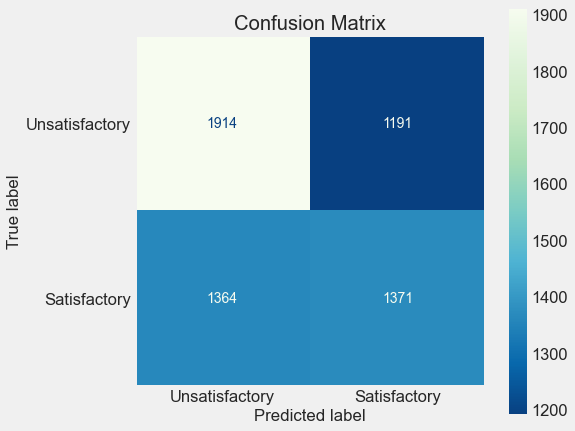

,Accuracy,F1,Recall,Precision
0,0.5625,0.517652,0.50128,0.535129


time: 553 ms


In [73]:
f.confusion_report(rf, X_test, y_test)

## AdaBoost

In [74]:
ADA = AdaBoostClassifier(base_estimator=DT, random_state=2021)

time: 794 µs


In [75]:
ada = make_pipeline(preprocessing_ohe, ADA)

time: 1.05 ms


### Fitting Model

In [76]:
ada.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 1.79 s


In [77]:
# f.pickle_model(ada, 'ada')

time: 591 µs


### Cross Val Scores

In [78]:
# checking cross val scores
modeling.report(ada, X_train, y_train, 'ada', 'AdaBoost')

ada has an average Accuracy of 0.558397091468891
ada has an average F1 of 0.5176582000792521
ada has an average Recall of 0.5065238328800106
ada has an average Precision of 0.5296880367549935
time: 6.03 s


### Test Data Confusion Matrix

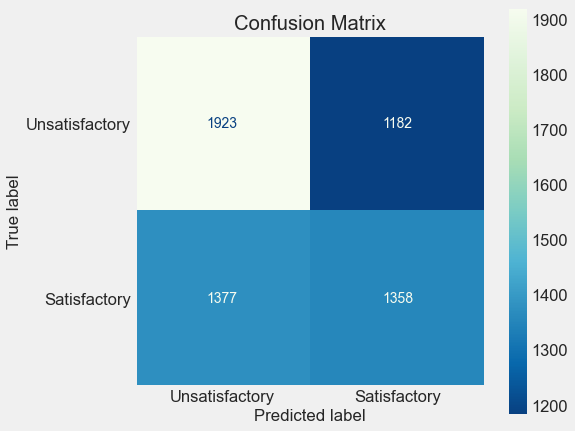

,Accuracy,F1,Recall,Precision
0,0.561815,0.514882,0.496527,0.534646


time: 405 ms


In [79]:
f.confusion_report(ada, X_test, y_test)

## XGBoost

In [80]:
XGB = XGBClassifier(use_label_encoder=False)

time: 871 µs


In [81]:
xgb = make_pipeline(preprocessing_ohe, XGB)

time: 970 µs


### Fitting Model

In [82]:
%%capture --no-display
xgb.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>)])),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               impo...pe='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
            

time: 586 ms


In [83]:
# f.pickle_model(xgb, 'xgb')

time: 944 µs


### Cross Val Scores

In [84]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb, X_train, y_train, 'xgb', 'XGBoost')

time: 3.48 s


### Test Data Confusion Matrix

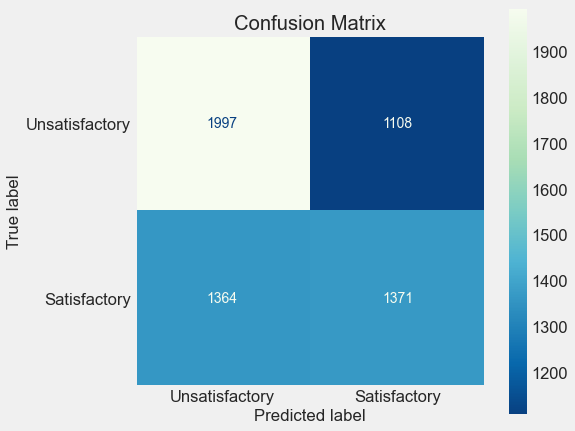

,Accuracy,F1,Recall,Precision
0,0.576712,0.525892,0.50128,0.553046


time: 493 ms


In [85]:
%%capture --no-display
f.confusion_report(xgb, X_test, y_test)

## Model Summary 1

In [86]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.531739,0.000000,0.000000,0.000000,0.269898,Baseline DummyCFL
1,knn,0.541671,0.499250,0.488113,0.511005,8.359409,KNN
2,dt,0.552175,0.479419,0.440447,0.526078,1.015692,Decision Tree
3,bclf,0.556056,0.511556,0.496645,0.527522,6.680028,Bagging CLF
4,rf,0.557655,0.509738,0.491162,0.529836,12.323708,Random Forest
5,ada,0.558397,0.517658,0.506524,0.529688,6.023385,AdaBoost
10,xgb,0.581915,0.532779,0.509202,0.558725,3.477120,XGBoost
6,svc,0.595844,0.535850,0.498232,0.579674,60.006772,Support Vector Classifier
7,fsm,0.597784,0.550146,0.525294,0.577553,0.306355,FSM Naive Bayes
8,lsvc,0.599383,0.546984,0.516637,0.581250,0.928145,Linear SVC


time: 10.5 ms


# Adding STUDENTVLE Features (click_sum, num_activities)

In [87]:
df = db.sv_si()

time: 40 s


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29228 entries, 0 to 29227
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                29228 non-null  int64   
 1   row_id                29228 non-null  object  
 2   code_module           29228 non-null  object  
 3   code_presentation     29228 non-null  object  
 4   id_student            29228 non-null  object  
 5   id_site               29228 non-null  object  
 6   date                  29228 non-null  object  
 7   sum_click             29228 non-null  object  
 8   gender                29228 non-null  object  
 9   region                29228 non-null  object  
 10  highest_education     29228 non-null  object  
 11  imd_band              28174 non-null  object  
 12  age_band              29228 non-null  object  
 13  num_of_prev_attempts  29228 non-null  int64   
 14  studied_credits       29228 non-null  int64   
 15  di

In [89]:
drops = ['row_id', 'code_module', 'code_presentation', 'studied_credits',
         'id_student', 'id_site', 'date', 'sum_click', 'final_result']

time: 807 µs


In [90]:
df = db.pipe_cleaner(df, drops)

time: 81.9 ms


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26470 entries, 0 to 29227
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                26470 non-null  int64   
 1   gender                26470 non-null  object  
 2   region                26470 non-null  object  
 3   highest_education     26470 non-null  object  
 4   imd_band              26470 non-null  object  
 5   age_band              26470 non-null  object  
 6   num_of_prev_attempts  26470 non-null  int64   
 7   disability            26470 non-null  object  
 8   click_sum             26470 non-null  int64   
 9   num_activities        26470 non-null  int64   
 10  course_load           26470 non-null  category
dtypes: category(1), int64(4), object(6)
memory usage: 2.2+ MB
time: 16.8 ms


In [92]:
df.head()

,target,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,disability,click_sum,num_activities,course_load
0,1,Male,Yorkshire Region,A Level or Equivalent,20-30%,0-35,0,No,744,243,Light
1,1,Male,South Region,Lower Than A Level,80-90%,35-55,0,No,4104,913,Light
2,1,Male,North Western Region,A Level or Equivalent,30-40%,0-35,0,No,1944,781,Light
3,1,Male,London Region,HE Qualification,60-70%,0-35,0,No,1150,313,Light
4,1,Female,London Region,Lower Than A Level,30-40%,35-55,0,No,1896,572,Light


time: 11.6 ms


In [93]:
df.describe()

,target,num_of_prev_attempts,click_sum,num_activities
count,26470.000000,26470.000000,26470.000000,26470.000000
mean,0.530110,0.144125,1338.822629,360.084133
std,0.499102,0.452979,1719.149524,375.345601
min,0.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,259.000000,93.000000
50%,1.000000,0.000000,731.500000,239.000000
75%,1.000000,0.000000,1740.000000,500.000000
max,1.000000,6.000000,24139.000000,2953.000000


time: 20 ms


## Creating Holdout Data

In [94]:
# splitting data & target
X, y = f.X_y(df)

time: 5.88 ms


In [95]:
# splitting traing and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 16.8 ms


## Creating Training Data

In [96]:
# train test split
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 14.2 ms


## MinMax Scaling
Since we've added numerical columns with very different scales to the data, we'll implement some scaling in the pipeline. K-Nearest Neighbors in particular is sensitive to differences in feature scale, and scaling can also help speed up convergence is certain algorithms.

## Naive Bayes Classifier

In [97]:
mnb_svsi = make_pipeline(preprocessing_mm, mnb)

time: 899 µs


### Fitting Model

In [98]:
mnb_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f10>)])),
                ('multinomialnb', MultinomialNB())])

time: 76.1 ms


### Saving Model

In [99]:
# f.pickle_model(mnb_svsi, 'mnb_svsi')

time: 675 µs


### Cross Val Scores

In [100]:
# checking cross val scores
modeling.report(mnb_svsi, X_train, y_train, ' mnb_svsi',\
                'Naive Bayes SVSI/MinMax()')

 mnb_svsi has an average Accuracy of 0.6543761405158375
 mnb_svsi has an average F1 of 0.6925603396146529
 mnb_svsi has an average Recall of 0.7345733088998427
 mnb_svsi has an average Precision of 0.6551948032333026
time: 316 ms


### Test Data Confusion Matrix

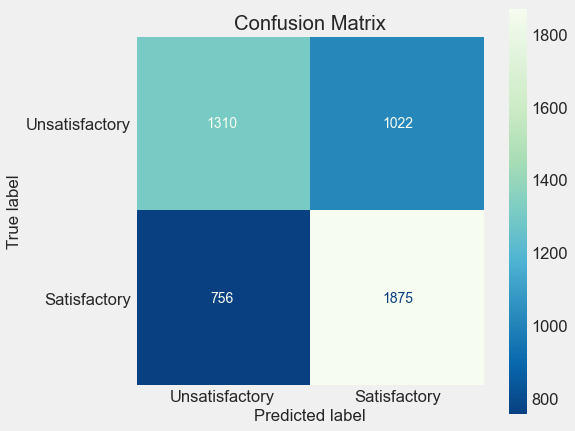

,Accuracy,F1,Recall,Precision
0,0.641749,0.678365,0.712657,0.647221


time: 257 ms


In [101]:
f.confusion_report(mnb_svsi, X_test, y_test)

## KNeighborsClassifier

In [102]:
knn_svsi = make_pipeline(preprocessing_mm, KNN)

time: 1.01 ms


### Fitting Model

In [103]:
knn_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f10>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 67.1 ms


In [104]:
# f.pickle_model(knn_svsi, 'knn_svsi')

time: 636 µs


### Cross Val Scores

In [105]:
# checking cross val scores
modeling.report(knn_svsi, X_train, y_train, 'knn_svsi',\
                'KNN SVSI/MinMax()')

knn_svsi has an average Accuracy of 0.6893003963902342
knn_svsi has an average F1 of 0.7091893738334247
knn_svsi has an average Recall of 0.7146826495728553
knn_svsi has an average Precision of 0.7038899042319293
time: 7.02 s


### Test Data Confusion Matrix

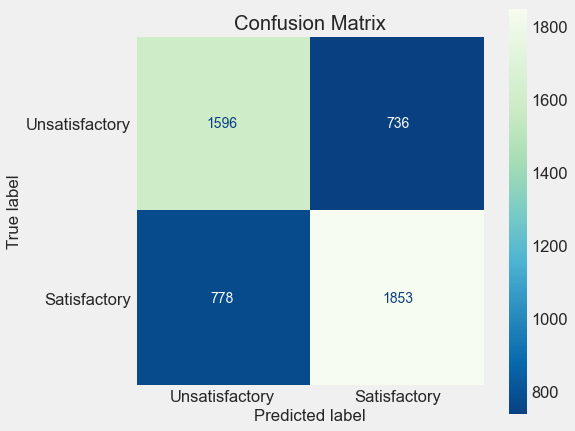

,Accuracy,F1,Recall,Precision
0,0.694943,0.709962,0.704295,0.71572


time: 14.6 s


In [106]:
f.confusion_report(knn_svsi, X_test, y_test)

## Logistic Regression Classifier

In [107]:
logreg_svsi = make_pipeline(preprocessing_mm, LR)

time: 943 µs


### Fitting Model

In [108]:
logreg_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f10>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 189 ms


In [109]:
# f.pickle_model(logreg_svsi, 'logreg_svsi')

time: 683 µs


### Cross Val Scores

In [110]:
# checking cross val scores
modeling.report(logreg_svsi, X_train, y_train, 'logreg_svsi',\
                'LogReg SVSI/MinMax()')

logreg_svsi has an average Accuracy of 0.7764117693902638
logreg_svsi has an average F1 of 0.7806589306985934
logreg_svsi has an average Recall of 0.7507880282317586
logreg_svsi has an average Precision of 0.8131872533673301
time: 962 ms


### Test Data Confusion Matrix

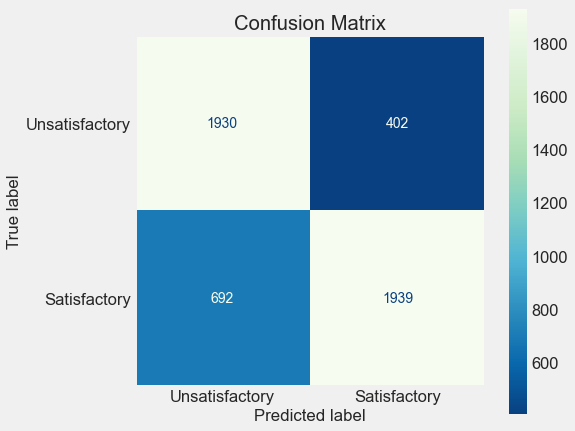

,Accuracy,F1,Recall,Precision
0,0.779569,0.779968,0.736982,0.828279


time: 241 ms


In [111]:
f.confusion_report(logreg_svsi, X_test, y_test)

## Support Vector Machine

In [112]:
svc_svsi= make_pipeline(preprocessing_mm, SVC)

time: 852 µs


### Fitting Model

In [113]:
svc_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f10>)])),
                ('svc', SVC())])

time: 9.92 s


In [114]:
# f.pickle_model(svc, 'svc_svsi')

time: 608 µs


### Cross Val Scores

In [115]:
# checking cross val scores
modeling.report(svc_svsi, X_train, y_train, 'svc_svsi',\
                'Support Vector CLF SVSI/MinMax()')

svc_svsi has an average Accuracy of 0.7563975028610888
svc_svsi has an average F1 of 0.7601159371740982
svc_svsi has an average Recall of 0.7281122399426568
svc_svsi has an average Precision of 0.7952089352667286
time: 37.3 s


### Test Data Confusion Matrix

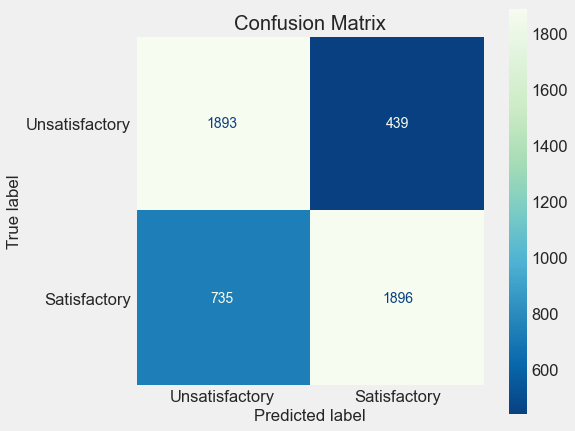

,Accuracy,F1,Recall,Precision
0,0.76345,0.763592,0.720639,0.811991


time: 10.6 s


In [116]:
f.confusion_report(svc_svsi, X_test, y_test)

## Linear Support Vector Machine

In [117]:
lsvc_svsi = make_pipeline(preprocessing_mm, LSVC)

time: 866 µs


### Fitting Model

In [118]:
lsvc_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f10>)])),
                ('linearsvc', LinearSVC())])

time: 223 ms


In [119]:
# f.pickle_model(lsvc_svsi, 'lsvc_svsi')

time: 628 µs


### Cross Val Scores

In [120]:
# checking cross val scores
modeling.report(lsvc_svsi, X_train, y_train, 'lsvc_svsi',\
                'Linear SVC SVSI/MinMax()')

lsvc_svsi has an average Accuracy of 0.7727180377521599
lsvc_svsi has an average F1 of 0.7740706247433213
lsvc_svsi has an average Recall of 0.7346983659902506
lsvc_svsi has an average Precision of 0.8181077955874312
time: 905 ms


### Test Data Confusion Matrix

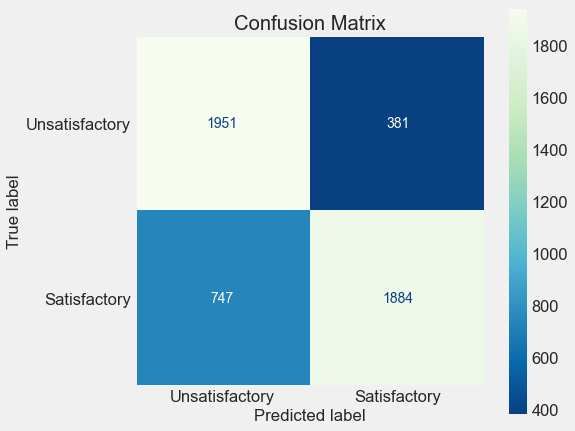

,Accuracy,F1,Recall,Precision
0,0.772718,0.769608,0.716078,0.831788


time: 273 ms


In [121]:
f.confusion_report(lsvc_svsi, X_test, y_test)

## Decision Tree

In [122]:
dt_svsi = make_pipeline(preprocessing_mm, DT)

time: 912 µs


### Fitting Model

In [123]:
dt_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f10>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 580 ms


In [124]:
# f.pickle_model(dt_svsi, 'dt_svsi')

time: 884 µs


### Cross Val Scores

In [125]:
# checking cross val scores
modeling.report(dt_svsi, X_train, y_train, 'dt_svsi',\
                'Decision Tree CLF SVSI/MinMax()')

dt_svsi has an average Accuracy of 0.7104569778645461
dt_svsi has an average F1 of 0.7258840620131328
dt_svsi has an average Recall of 0.7231700768402777
dt_svsi has an average Precision of 0.7287000150751964
time: 1.99 s


### Test Data Confusion Matrix

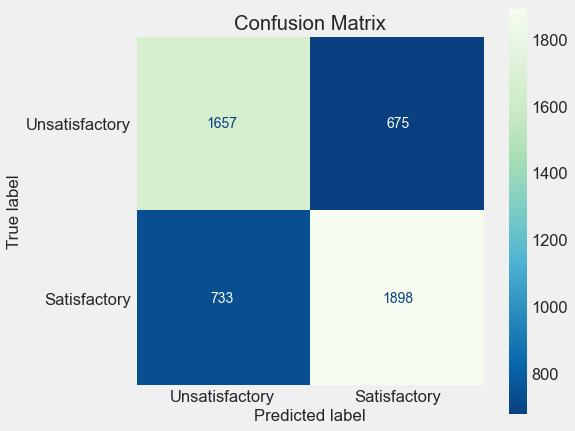

,Accuracy,F1,Recall,Precision
0,0.716301,0.729439,0.721399,0.73766


time: 232 ms


In [126]:
f.confusion_report(dt_svsi, X_test, y_test)

## Bagging Classifier

In [127]:
bclf_svsi = make_pipeline(preprocessing_mm, BCLF)

time: 799 µs


### Fitting Model

In [128]:
bclf_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f10>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 2.81 s


In [129]:
# f.pickle_model(bclf_svsi, 'bclf_svsi')

time: 593 µs


### Cross Val Scores

In [130]:
# checking cross val scores
modeling.report(bclf_svsi, X_train, y_train, 'bclf_svsi',\
                'Bagging CLF SVSI/MinMax()')

bclf_svsi has an average Accuracy of 0.754314801659375
bclf_svsi has an average F1 of 0.7678301466778832
bclf_svsi has an average Recall of 0.7663740106001535
bclf_svsi has an average Precision of 0.7694231884167302
time: 10.1 s


### Test Data Confusion Matrix

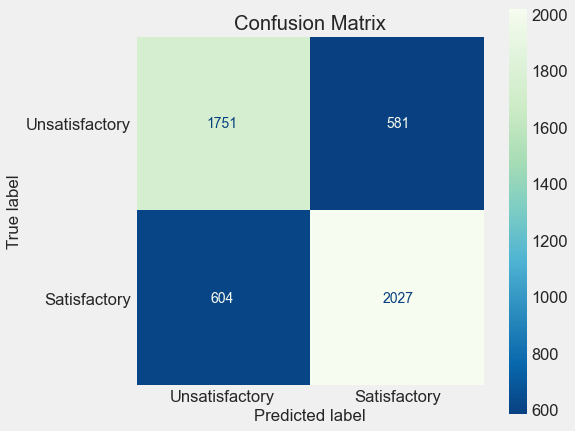

,Accuracy,F1,Recall,Precision
0,0.761233,0.773812,0.770429,0.777224


time: 293 ms


In [131]:
f.confusion_report(bclf_svsi, X_test, y_test)

## Random Forest Classifier

In [132]:
rf_svsi = make_pipeline(preprocessing_mm, RF)

time: 789 µs


### Fitting Model

In [133]:
rf_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f10>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 2.19 s


In [134]:
# f.pickle_model(rf_svsi, 'rf_svsi')

time: 640 µs


### Cross Val Scores

In [135]:
# checking cross val scores
modeling.report(rf_svsi, X_train, y_train, 'rf_svsi',\
                'Random Forest SVSI/MinMax()')

rf_svsi has an average Accuracy of 0.7726502920419883
rf_svsi has an average F1 of 0.7934224880288162
rf_svsi has an average Recall of 0.8236397232048327
rf_svsi has an average Precision of 0.7654787307125851
time: 9.67 s


### Test Data Confusion Matrix

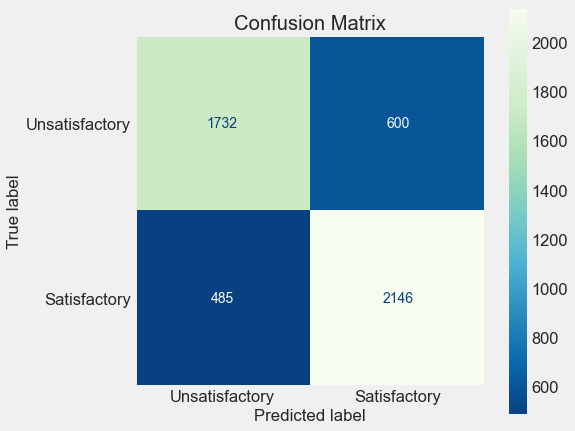

,Accuracy,F1,Recall,Precision
0,0.781382,0.798215,0.815659,0.7815


time: 516 ms


In [136]:
f.confusion_report(rf_svsi, X_test, y_test)

## AdaBoost

In [137]:
ada_svsi = make_pipeline(preprocessing_mm, ADA)

time: 978 µs


### Fitting Model

In [138]:
ada_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f10>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 502 ms


In [139]:
# f.pickle_model(ada_svsi, 'ada_svsi')

time: 622 µs


### Cross Val Scores

In [140]:
# checking cross val scores
modeling.report(ada_svsi, X_train, y_train, 'ada_svsi',\
                'AdaBoost SVSI/MinMax()')

ada_svsi has an average Accuracy of 0.7114647488817898
ada_svsi has an average F1 of 0.7262917324760971
ada_svsi has an average Recall of 0.7221564562127607
ada_svsi has an average Precision of 0.7305769110141108
time: 1.93 s


### Test Data Confusion Matrix

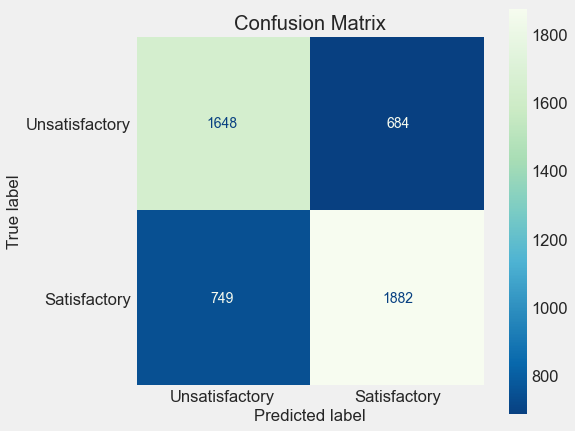

,Accuracy,F1,Recall,Precision
0,0.711263,0.724264,0.715317,0.733437


time: 252 ms


In [141]:
f.confusion_report(ada_svsi, X_test, y_test)

## XGBoost

In [142]:
xgb_svsi = make_pipeline(preprocessing_mm, XGB)

time: 882 µs


### Fitting Model

In [143]:
%%capture --no-display
xgb_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f10>)])),
                ('xgbclassifier',
                 XGBClassifier(ba...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 1.31 s


In [144]:
# f.pickle_model(xgb_svsi, 'xgb_svsi')

time: 796 µs


### Cross Val Scores

In [145]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_svsi, X_train, y_train, 'xgb_svsi',\
                'XGBoost SVSI/MinMax()')

time: 5.85 s


### Test Data Confusion Matrix

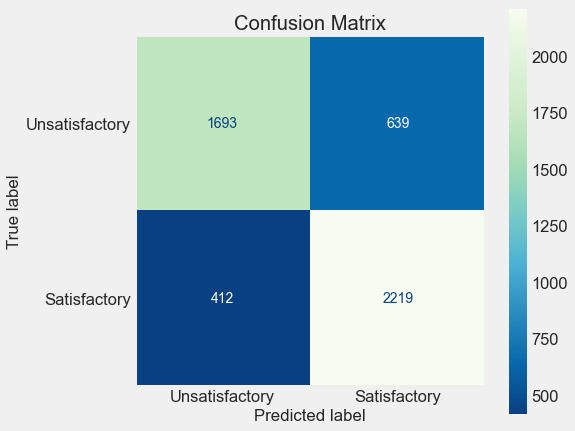

,Accuracy,F1,Recall,Precision
0,0.788233,0.808526,0.843406,0.776417


time: 388 ms


In [146]:
%%capture --no-display
f.confusion_report(xgb_svsi, X_test, y_test)

## Model Summary 2

In [147]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.531739,0.000000,0.000000,0.000000,0.269898,Baseline DummyCFL
1,knn,0.541671,0.499250,0.488113,0.511005,8.359409,KNN
2,dt,0.552175,0.479419,0.440447,0.526078,1.015692,Decision Tree
3,bclf,0.556056,0.511556,0.496645,0.527522,6.680028,Bagging CLF
4,rf,0.557655,0.509738,0.491162,0.529836,12.323708,Random Forest
5,ada,0.558397,0.517658,0.506524,0.529688,6.023385,AdaBoost
6,xgb,0.581915,0.532779,0.509202,0.558725,3.477120,XGBoost
7,svc,0.595844,0.535850,0.498232,0.579674,60.006772,Support Vector Classifier
8,fsm,0.597784,0.550146,0.525294,0.577553,0.306355,FSM Naive Bayes
9,lsvc,0.599383,0.546984,0.516637,0.581250,0.928145,Linear SVC


time: 10.8 ms


## Voting Classifier
Using the top three model in a voting classifier.

In [148]:
clf1 = LR
clf2 = RF
clf3 = XGB

estimators = [('lsvs',clf1), ('logreg', clf1), ('rf', clf2), ('xgb', clf3)]

VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 1.25 ms


In [149]:
vc_svsi = make_pipeline(preprocessing_mm, VC)

time: 1.15 ms


### Fitting Model

In [150]:
%%capture --no-display
vc_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f10>)])),
                ('votingclassifier',
                 VotingClassif...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
   

time: 4.11 s


In [151]:
# f.pickle_model(vc_svsi, 'vc_svsi')

time: 612 µs


### Cross Val Scores

In [152]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_svsi, X_train, y_train, 'vc_svsi',\
                'Voting CLF SVSI/MinMax()')

time: 16.9 s


### Test Data Confusion Matrix

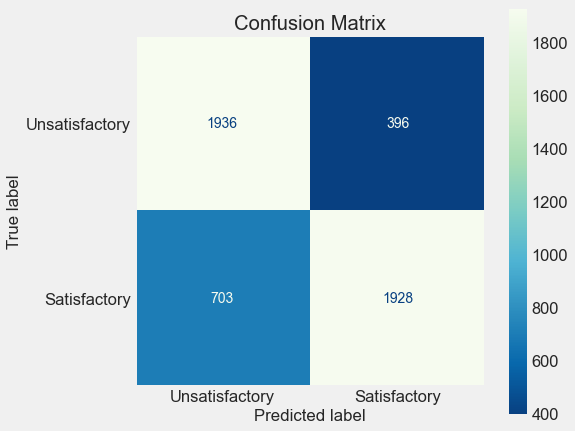

,Accuracy,F1,Recall,Precision
0,0.778561,0.778204,0.732801,0.829604


time: 861 ms


In [153]:
%%capture --no-display
f.confusion_report(vc_svsi, X_test, y_test)

## Model Summary 3

In [154]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.531739,0.000000,0.000000,0.000000,0.269898,Baseline DummyCFL
1,knn,0.541671,0.499250,0.488113,0.511005,8.359409,KNN
2,dt,0.552175,0.479419,0.440447,0.526078,1.015692,Decision Tree
3,bclf,0.556056,0.511556,0.496645,0.527522,6.680028,Bagging CLF
4,rf,0.557655,0.509738,0.491162,0.529836,12.323708,Random Forest
5,ada,0.558397,0.517658,0.506524,0.529688,6.023385,AdaBoost
6,xgb,0.581915,0.532779,0.509202,0.558725,3.477120,XGBoost
7,svc,0.595844,0.535850,0.498232,0.579674,60.006772,Support Vector Classifier
8,fsm,0.597784,0.550146,0.525294,0.577553,0.306355,FSM Naive Bayes
9,lsvc,0.599383,0.546984,0.516637,0.581250,0.928145,Linear SVC


time: 14.3 ms


## Neural Network

### Create Model

In [155]:
def create_model():
    # building model
    model = Sequential()
    model.add(Dense(64, input_dim=38, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    return model

time: 1.44 ms


In [156]:
NN = KerasClassifier(build_fn=create_model,
                     epochs=10,
                     batch_size=32,
                     verbose=0)

time: 1.18 ms


### Pipeline

In [157]:
nn_svsi = make_pipeline(preprocessing_mm, NN)

time: 930 µs


### Fitting Models

In [158]:
# %%capture --no-display
nn_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f10>)])),
                ('kerasclassifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x1ccab6730>)])

time: 5.47 s


In [159]:
# f.pickle_model(nn_svsi, 'nn_svsi')

time: 628 µs


### Cross Val Scores

In [160]:
%%capture --no-display
modeling.report(nn_svsi, X_train, y_train, 'nn_svsi',\
                'Neural Net SVSI/MinMax()')

time: 22.8 s


### Test Data Confusion Matrix

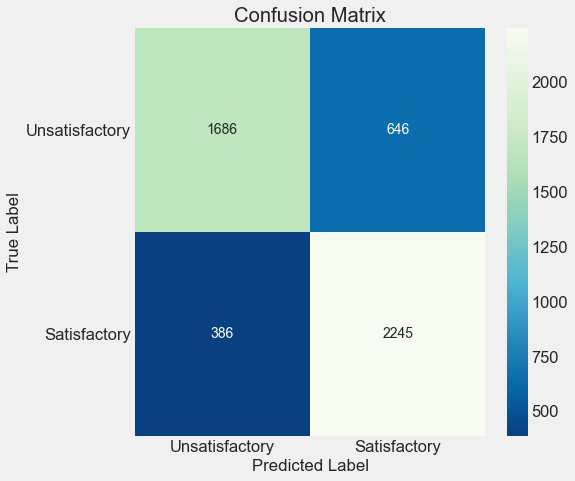

,Accuracy,F1,Recall,Precision
0,0.792061,0.813111,0.853288,0.776548


time: 1.15 s


In [161]:
%%capture --no-display
f.confusion_report_nn(nn_svsi, X_test, y_test)

## Model Summary 4

In [162]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.531739,0.000000,0.000000,0.000000,0.269898,Baseline DummyCFL
1,knn,0.541671,0.499250,0.488113,0.511005,8.359409,KNN
2,dt,0.552175,0.479419,0.440447,0.526078,1.015692,Decision Tree
3,bclf,0.556056,0.511556,0.496645,0.527522,6.680028,Bagging CLF
4,rf,0.557655,0.509738,0.491162,0.529836,12.323708,Random Forest
5,ada,0.558397,0.517658,0.506524,0.529688,6.023385,AdaBoost
6,xgb,0.581915,0.532779,0.509202,0.558725,3.477120,XGBoost
7,svc,0.595844,0.535850,0.498232,0.579674,60.006772,Support Vector Classifier
8,fsm,0.597784,0.550146,0.525294,0.577553,0.306355,FSM Naive Bayes
9,lsvc,0.599383,0.546984,0.516637,0.581250,0.928145,Linear SVC


time: 16.3 ms


In [163]:
%%capture --no-display
# df = modeling.history
# f.df_plot(df, 'modeling_history')

time: 1.48 ms


# Adding Assessment Data Features

In [164]:
# path = os.path.join(gparent, 'data/processed/df2.csv')
# df = pd.read_csv(path)

time: 955 µs


In [165]:
# df.info()

time: 740 µs


In [4]:
df = db.df_a()

time: 42.7 s


In [5]:
drops = ['row_id', 'code_module', 'code_presentation', 'sum_click', 'date',
         'id_student', 'id_site', 'studied_credits', 'final_result']

time: 779 µs


In [6]:
# %%capture --no-display
df = db.pipe_cleaner_wa(df, drops)

time: 88 ms


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22579 entries, 0 to 26330
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                22579 non-null  int64   
 1   gender                22579 non-null  object  
 2   region                22579 non-null  object  
 3   highest_education     22579 non-null  object  
 4   imd_band              22579 non-null  object  
 5   age_band              22579 non-null  object  
 6   num_of_prev_attempts  22579 non-null  int64   
 7   disability            22579 non-null  object  
 8   click_sum             22579 non-null  int64   
 9   num_activities        22579 non-null  int64   
 10  course_load           22579 non-null  category
 11  mean_score            22579 non-null  float64 
 12  median_score          22579 non-null  float64 
 13  weighted_ave          22579 non-null  float64 
dtypes: category(1), float64(3), int64(4), object(6)
memory

In [9]:
df.weighted_ave.describe()

count    22579.000000
mean        62.558422
std         47.311616
min          0.000000
25%         18.000000
50%         65.300000
75%         86.500000
max        195.640000
Name: weighted_ave, dtype: float64

time: 6.44 ms


## Creating Holdout Data

In [170]:
# splitting data & target
X, y = f.X_y(df)

time: 4.47 ms


In [171]:
# splitting traing and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 19.9 ms


## Creating Training Data

In [172]:
# train test split
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 18.8 ms


## Naive Bayes Classifier

In [173]:
mnb_assess = make_pipeline(preprocessing_mm, mnb)

time: 937 µs


### Fitting Model

In [174]:
mnb_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f10>)])),
                ('multinomialnb', MultinomialNB())])

time: 74 ms


### Saving Model

In [175]:
# f.pickle_model(mnb_assess, 'mnb_assess')

time: 907 µs


### Cross Val Scores

In [176]:
# checking cross val scores
modeling.report(mnb_assess, X_train, y_train, 'mnb_assess',\
                'Naive Bayes ASSESS/MinMax()')

mnb_assess has an average Accuracy of 0.6848818897637796
mnb_assess has an average F1 of 0.7533026817599586
mnb_assess has an average Recall of 0.8475728155339806
mnb_assess has an average Precision of 0.6780009457305607
time: 387 ms


### Test Data Confusion Matrix

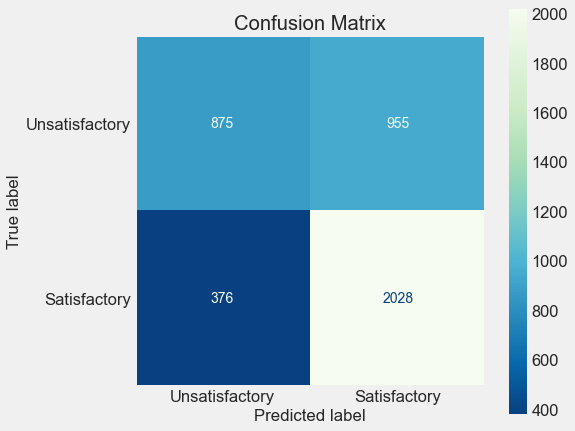

,Accuracy,F1,Recall,Precision
0,0.68564,0.752924,0.843594,0.679852


time: 301 ms


In [177]:
f.confusion_report(mnb_assess, X_test, y_test)

## KNeighborsClassifier

In [178]:
knn_assess = make_pipeline(preprocessing_mm, KNN)

time: 978 µs


### Fitting Model

In [179]:
knn_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f10>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 83.7 ms


In [180]:
# f.pickle_model(knn_assess, 'knn_assess')

time: 1.11 ms


### Cross Val Scores

In [181]:
# checking cross val scores
modeling.report(knn_assess, X_train, y_train, 'knn_assess',\
                'KNN ASSESS/MinMax()')

knn_assess has an average Accuracy of 0.6972440944881889
knn_assess has an average F1 of 0.7447478775783425
knn_assess has an average Recall of 0.7779472954230235
knn_assess has an average Precision of 0.7143378521257929
time: 6.43 s


### Test Data Confusion Matrix

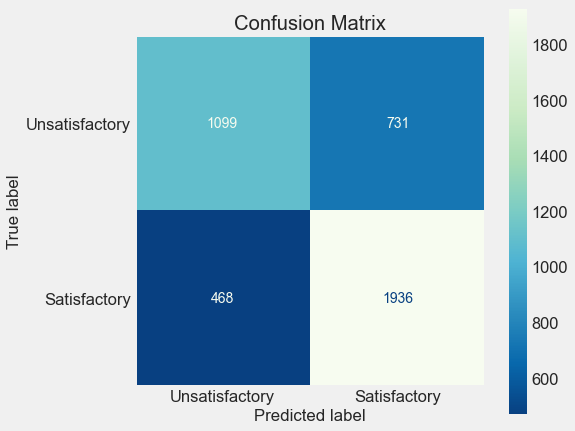

,Accuracy,F1,Recall,Precision
0,0.716816,0.763557,0.805324,0.725909


time: 11.5 s


In [182]:
f.confusion_report(knn_assess, X_test, y_test)

## Logistic Regression Classifier

In [183]:
logreg_assess = make_pipeline(preprocessing_mm, LR)

time: 1.1 ms


### Fitting Model

In [184]:
logreg_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f10>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 395 ms


In [185]:
# f.pickle_model(logreg_assess, 'logreg_assess')

time: 580 µs


### Cross Val Scores

In [186]:
# checking cross val scores
modeling.report(logreg_assess, X_train, y_train, 'logreg_assess',\
                'LogReg ASSESS/MinMax()')

logreg_assess has an average Accuracy of 0.7932283464566929
logreg_assess has an average F1 of 0.8193619084568506
logreg_assess has an average Recall of 0.8260748959778086
logreg_assess has an average Precision of 0.8128257293597161
time: 924 ms


### Test Data Confusion Matrix

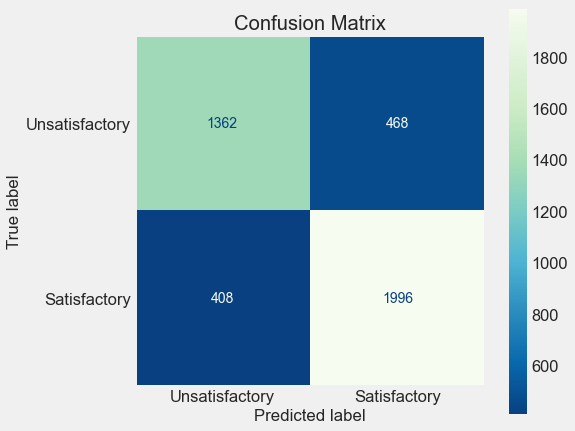

,Accuracy,F1,Recall,Precision
0,0.793103,0.820049,0.830283,0.810065


time: 256 ms


In [187]:
f.confusion_report(logreg_assess, X_test, y_test)

## Support Vector Machine

In [188]:
svc_assess= make_pipeline(preprocessing_mm, SVC)

time: 844 µs


### Fitting Model

In [189]:
svc_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f10>)])),
                ('svc', SVC())])

time: 8.87 s


In [190]:
# f.pickle_model(svc_assess, 'svc_assess')

time: 831 µs


### Cross Val Scores

In [191]:
# checking cross val scores
modeling.report(svc_assess, X_train, y_train, 'svc_assess',\
                'Support Vector CLF ASSESS/MinMax()')

svc_assess has an average Accuracy of 0.7930708661417322
svc_assess has an average F1 of 0.821878475766089
svc_assess has an average Recall of 0.8409153952843272
svc_assess has an average Precision of 0.8037376941793951
time: 28.2 s


### Test Data Confusion Matrix

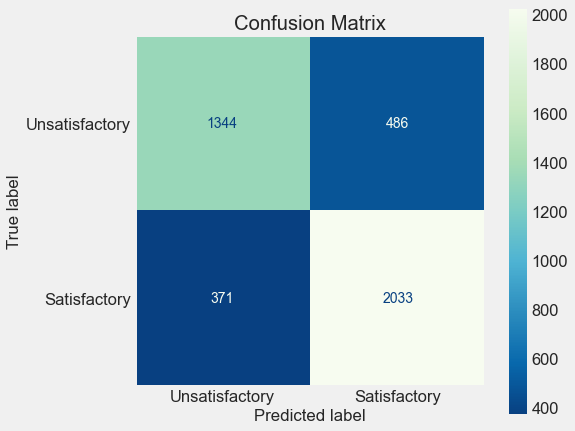

,Accuracy,F1,Recall,Precision
0,0.797591,0.825919,0.845674,0.807066


time: 7.29 s


In [192]:
f.confusion_report(svc_assess, X_test, y_test)

## Linear Support Vector Machine

In [193]:
lsvc_assess = make_pipeline(preprocessing_mm, LSVC)

time: 833 µs


### Fitting Model

In [194]:
lsvc_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f10>)])),
                ('linearsvc', LinearSVC())])

time: 203 ms


In [195]:
# f.pickle_model(lsvc_assess, 'lsvc_assess')

time: 736 µs


### Cross Val Scores

In [196]:
# checking cross val scores
modeling.report(lsvc_assess, X_train, y_train, 'lsvc_assess',\
                'Linear SVC ASSESS/MinMax()')

lsvc_assess has an average Accuracy of 0.7925196850393701
lsvc_assess has an average F1 of 0.8181890221572873
lsvc_assess has an average Recall of 0.8223300970873787
lsvc_assess has an average Precision of 0.8141447754619968
time: 849 ms


### Test Data Confusion Matrix

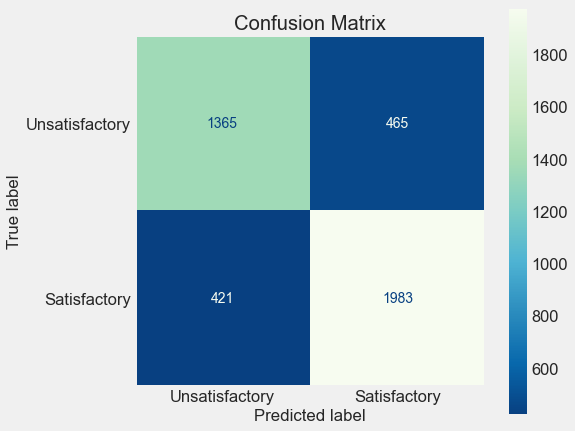

,Accuracy,F1,Recall,Precision
0,0.790742,0.817395,0.824875,0.810049


time: 228 ms


In [197]:
f.confusion_report(lsvc_assess, X_test, y_test)

## Decision Tree

In [198]:
dt_assess = make_pipeline(preprocessing_mm, DT)

time: 941 µs


### Fitting Model

In [199]:
dt_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f10>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 423 ms


In [200]:
# f.pickle_model(dt_assess, 'dt_assess')

time: 599 µs


### Cross Val Scores

In [201]:
# checking cross val scores
modeling.report(dt_assess, X_train, y_train, 'dt_assess',\
                'Decision Tree CLF ASSESS/MinMax()')

dt_assess has an average Accuracy of 0.815275590551181
dt_assess has an average F1 of 0.8365506198532066
dt_assess has an average Recall of 0.8327323162274618
dt_assess has an average Precision of 0.8404889817452281
time: 1.59 s


### Test Data Confusion Matrix

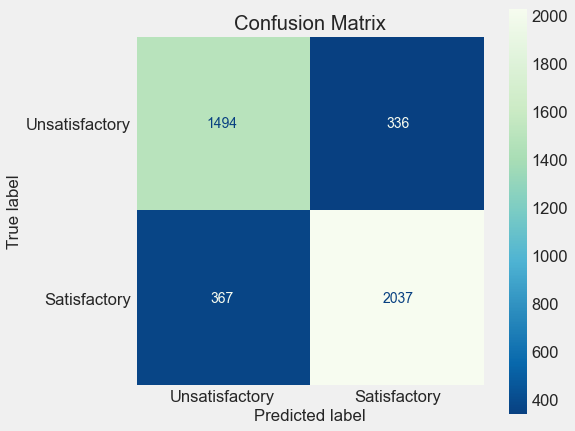

,Accuracy,F1,Recall,Precision
0,0.833963,0.852837,0.847338,0.858407


time: 229 ms


In [202]:
f.confusion_report(dt_assess, X_test, y_test)

## Bagging Classifier

In [203]:
bclf_assess = make_pipeline(preprocessing_mm, BCLF)

time: 834 µs


### Fitting Model

In [204]:
bclf_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f10>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 2.25 s


In [205]:
# f.pickle_model(bclf_assess, 'bclf_assess')

time: 627 µs


### Cross Val Scores

In [206]:
# checking cross val scores
modeling.report(bclf_assess, X_train, y_train, 'bclf_assess',\
                'Bagging CLF ASSESS/MinMax()')

bclf_assess has an average Accuracy of 0.8565354330708661
bclf_assess has an average F1 of 0.8752403632178073
bclf_assess has an average Recall of 0.8864077669902913
bclf_assess has an average Precision of 0.8644538123640778
time: 8.63 s


### Test Data Confusion Matrix

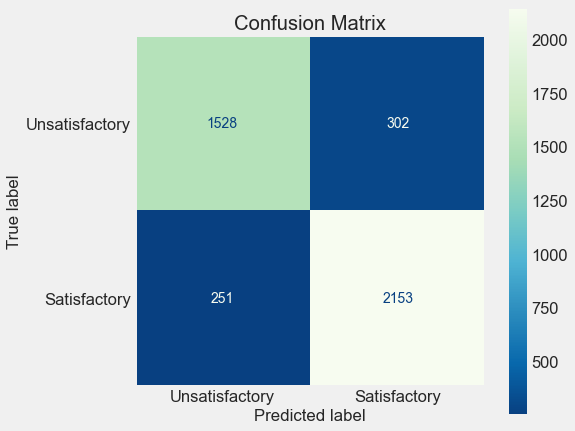

,Accuracy,F1,Recall,Precision
0,0.869391,0.886191,0.895591,0.876986


time: 385 ms


In [207]:
f.confusion_report(bclf_assess, X_test, y_test)

## Random Forest Classifier

In [208]:
rf_assess = make_pipeline(preprocessing_mm, RF)

time: 882 µs


### Fitting Model

In [209]:
rf_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f10>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 2.26 s


In [210]:
# f.pickle_model(rf_assess, 'rf_assess')

time: 836 µs


### Cross Val Scores

In [211]:
# checking cross val scores
modeling.report(rf_assess, X_train, y_train, 'rf_assess',\
                'Random Forest ASSESS/MinMax()')

rf_assess has an average Accuracy of 0.8704724409448819
rf_assess has an average F1 of 0.8889377766455564
rf_assess has an average Recall of 0.9131761442441053
rf_assess has an average Precision of 0.8660244102290552
time: 10.5 s


### Test Data Confusion Matrix

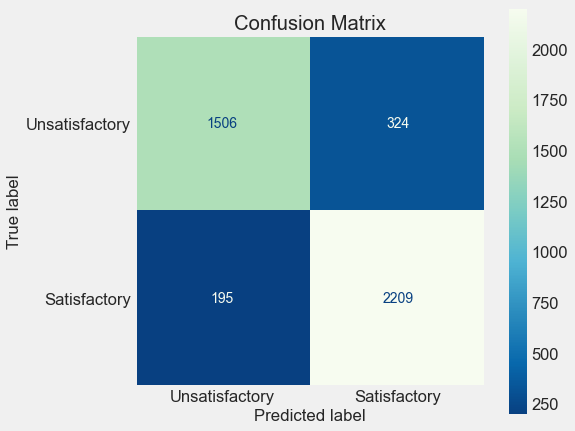

,Accuracy,F1,Recall,Precision
0,0.877421,0.894875,0.918885,0.872088


time: 568 ms


In [212]:
f.confusion_report(rf_assess, X_test, y_test)

## AdaBoost

In [213]:
ada_assess = make_pipeline(preprocessing_mm, ADA)

time: 940 µs


### Fitting Model

In [214]:
ada_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f10>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 544 ms


In [215]:
# f.pickle_model(ada_assess, 'ada_assess')

time: 748 µs


### Cross Val Scores

In [216]:
# checking cross val scores
modeling.report(ada_assess, X_train, y_train, 'ada_assess',\
                'AdaBoost ASSESS/MinMax()')

ada_assess has an average Accuracy of 0.8164566929133859
ada_assess has an average F1 of 0.8377166027249612
ada_assess has an average Recall of 0.8345353675450763
ada_assess has an average Precision of 0.840942816334155
time: 1.71 s


### Test Data Confusion Matrix

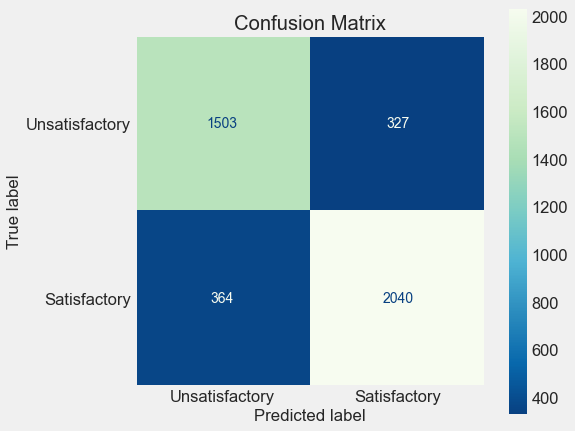

,Accuracy,F1,Recall,Precision
0,0.836797,0.855167,0.848586,0.86185


time: 304 ms


In [217]:
f.confusion_report(ada_assess, X_test, y_test)

## XGBoost

In [218]:
xgb_assess = make_pipeline(preprocessing_mm, XGB)

time: 1.14 ms


### Fitting Model

In [219]:
%%capture --no-display
xgb_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f10>)])),
                ('xgbclassifier',
                 XGBClassifier(ba...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 1.6 s


In [220]:
# f.pickle_model(xgb_assess, 'xgb_assess')

time: 1.09 ms


### Cross Val Scores

In [221]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_assess, X_train, y_train, 'xgb_assess',\
                'XGBoost ASSESS/MinMax()')

time: 7.73 s


### Test Data Confusion Matrix

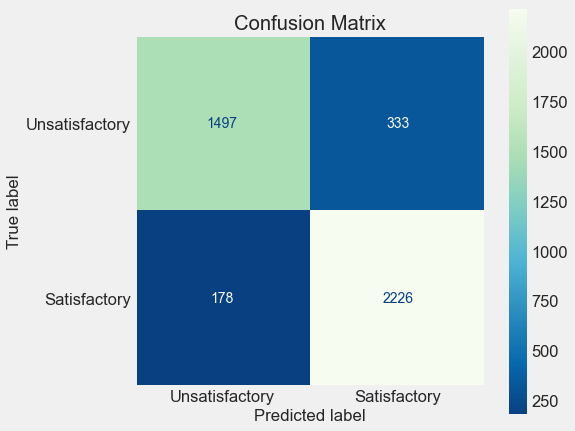

,Accuracy,F1,Recall,Precision
0,0.87931,0.897038,0.925957,0.869871


time: 398 ms


In [222]:
%%capture --no-display
f.confusion_report(xgb_assess, X_test, y_test)

## Model Summary 5

In [223]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.531739,0.000000,0.000000,0.000000,0.269898,Baseline DummyCFL
1,knn,0.541671,0.499250,0.488113,0.511005,8.359409,KNN
2,dt,0.552175,0.479419,0.440447,0.526078,1.015692,Decision Tree
3,bclf,0.556056,0.511556,0.496645,0.527522,6.680028,Bagging CLF
4,rf,0.557655,0.509738,0.491162,0.529836,12.323708,Random Forest
5,ada,0.558397,0.517658,0.506524,0.529688,6.023385,AdaBoost
6,xgb,0.581915,0.532779,0.509202,0.558725,3.477120,XGBoost
7,svc,0.595844,0.535850,0.498232,0.579674,60.006772,Support Vector Classifier
8,fsm,0.597784,0.550146,0.525294,0.577553,0.306355,FSM Naive Bayes
9,lsvc,0.599383,0.546984,0.516637,0.581250,0.928145,Linear SVC


time: 14.2 ms


## Voting Classifier
Using the top three model in a voting classifier.

In [224]:
clf1 = LR
clf2 = RF
clf3 = XGB

estimators = [('lsvs',clf1), ('logreg', clf1), ('rf', clf2), ('xgb', clf3)]

VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 1.1 ms


In [225]:
vc_assess = make_pipeline(preprocessing_mm, VC)

time: 1.09 ms


### Fitting Model

In [226]:
%%capture --no-display
vc_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f10>)])),
                ('votingclassifier',
                 VotingClassif...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
   

time: 4.02 s


In [227]:
# f.pickle_model(vc_assess, 'vc_assess')

time: 710 µs


### Cross Val Scores

In [228]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_assess, X_train, y_train, 'vc_assess',\
                'Voting CLF ASSESS/MinMax()')

time: 17.6 s


### Test Data Confusion Matrix

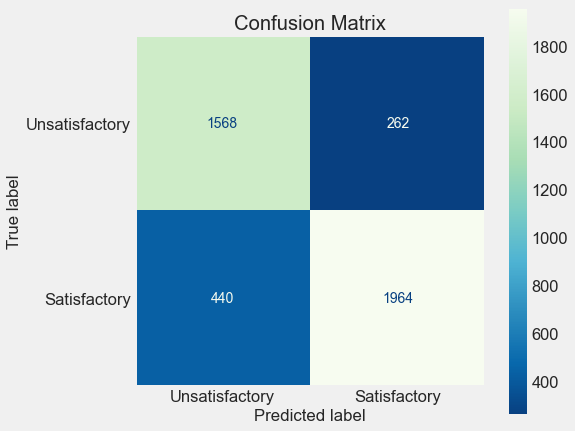

,Accuracy,F1,Recall,Precision
0,0.834199,0.84838,0.816972,0.8823


time: 771 ms


In [229]:
%%capture --no-display
f.confusion_report(vc_assess, X_test, y_test)

## Model Summary 6

In [230]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.531739,0.000000,0.000000,0.000000,0.269898,Baseline DummyCFL
1,knn,0.541671,0.499250,0.488113,0.511005,8.359409,KNN
2,dt,0.552175,0.479419,0.440447,0.526078,1.015692,Decision Tree
3,bclf,0.556056,0.511556,0.496645,0.527522,6.680028,Bagging CLF
4,rf,0.557655,0.509738,0.491162,0.529836,12.323708,Random Forest
5,ada,0.558397,0.517658,0.506524,0.529688,6.023385,AdaBoost
6,xgb,0.581915,0.532779,0.509202,0.558725,3.477120,XGBoost
7,svc,0.595844,0.535850,0.498232,0.579674,60.006772,Support Vector Classifier
8,fsm,0.597784,0.550146,0.525294,0.577553,0.306355,FSM Naive Bayes
9,lsvc,0.599383,0.546984,0.516637,0.581250,0.928145,Linear SVC


time: 16.9 ms


## Neural Network

In [231]:
def create_model():
    # building model
    model = Sequential()
    model.add(Dense(64, input_dim=41, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    return model

time: 1.18 ms


In [232]:
NN2 = KerasClassifier(build_fn=create_model,
                     epochs=10,
                     batch_size=32,
                     verbose=0)

time: 1.44 ms


### Pipeline

In [233]:
nn_assess = make_pipeline(preprocessing_mm, NN2)

time: 1.03 ms


### Fitting Models

In [234]:
%%capture --no-display
nn_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c015f10>)])),
                ('kerasclassifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x180c76c70>)])

time: 5.77 s


In [235]:
# f.pickle_model(nn_assess, 'nn_assess')

time: 710 µs


### Cross Val Scores

In [236]:
%%capture --no-display
modeling.report(nn_assess, X_train, y_train, 'nn_assess',\
                'Neural Net ASSESS/MinMax()')

time: 22.7 s


### Test Data Confusion Matrix

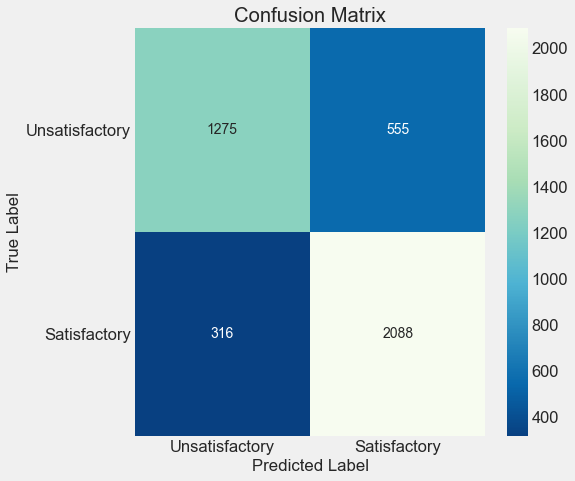

,Accuracy,F1,Recall,Precision
0,0.794284,0.827422,0.868552,0.790011


time: 774 ms


In [237]:
%%capture --no-display
f.confusion_report_nn(nn_assess, X_test, y_test)

## Model Summary 7

In [238]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.531739,0.000000,0.000000,0.000000,0.269898,Baseline DummyCFL
1,knn,0.541671,0.499250,0.488113,0.511005,8.359409,KNN
2,dt,0.552175,0.479419,0.440447,0.526078,1.015692,Decision Tree
3,bclf,0.556056,0.511556,0.496645,0.527522,6.680028,Bagging CLF
4,rf,0.557655,0.509738,0.491162,0.529836,12.323708,Random Forest
5,ada,0.558397,0.517658,0.506524,0.529688,6.023385,AdaBoost
6,xgb,0.581915,0.532779,0.509202,0.558725,3.477120,XGBoost
7,svc,0.595844,0.535850,0.498232,0.579674,60.006772,Support Vector Classifier
8,fsm,0.597784,0.550146,0.525294,0.577553,0.306355,FSM Naive Bayes
9,lsvc,0.599383,0.546984,0.516637,0.581250,0.928145,Linear SVC


time: 15 ms


In [239]:
Audio(sound_file, autoplay=True)

time: 16.5 ms


In [240]:
%%capture --no-display
# ma_df = modeling.history
# f.df_plot(ma_df, 'modeling_history')

time: 1.09 ms
[02:19:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:22:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:19:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:23:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to rest